# Capstone Project: Grab Challenge(Traffic Management)

# 1. Introduction

I'd like to introduce you to Joe. Joe is your daily commuter. He gets up at 6 and leaves at 6:30 for his 8 am job. An hour and a half seems like ample time for his commute. However, he encounters this:

<img src="https://s3.amazonaws.com/carmudi-blogs/carmudi-ph/wp-content/uploads/2018/12/31192909/117.jpg">

# 2. Problem statement and hypothesis


### Big Picture
The big picture here is that the Philippines loses about Php 3.5 billion a day due to traffic congestion in Metro Manila. If we continue to do nothing, this will increase to Php 5.4 billion in 2035.

Of course traffic is a multi-faceted problem that cannot be solved immediately. However, one of the first steps in alleviating traffic congestion is to understand travel patterns within the city.

With this said, can we use Grab's historical travel demand data to observe patterns in the city.

### Specific Problem
- Questions?
  - Why do we can't to predict demand?
  - What is Grab's business model

- Situation
  - Grab is a ride-hailing company
  - Business model is 20% of the fare goes to them

- Complication
  - They want to maximize revenue (by knowing which locations have high demand to match the number of drivers there)
  - From personal experience, high demand areas sometimes do not have enough cars

- Question
  - What are the locations that have high demand at a specific time

- Resolution
  - Using Grab's data on travel demand, we may be able to observe travel patterns within the city to know which locations have high demand at a specific time

- Call to Action
  - Knowing which locations have high demand, Grab would be able to find a way to deploy more vehicles in that location to maximize revenue (moving vehicles from low demand areas to high demand ones)

- Benefits: This would be beneficial to the following:
  - Government
    - They can observe which areas are in need of infrastructural development to ease traffic congestion
    - Allow them to create or mandate rules and laws, such as vehicle coding
    - Deploy more MMDA to make traffic management more bearable
  - Community
    - Knowing travel patterns would allow people to forsee travel time so they could avoid being late


# 3. Description of your data set and how it was obtained

I used the data set in the Grab Challenge on Traffic Management.

<img src="https://vectorlogo4u.com/wp-content/uploads/2018/09/grqab-vector-logo-720x340.png">
<img src="files/ye.png">




<h3> GOAL of GRAB CHALLENGE</h3>

"In this challenge, participants are to build a model trained on a historical demand dataset, that can forecast demand on a Hold-out test dataset. The model should be able to accurately forecast ahead by T+1 to T+5 time intervals (where each interval is 15-min) given all data up to time T."

# 4. Description of any pre-processing steps you took (Data Preparation)

In [1]:
import pandas as pd
from datetime import datetime,timedelta

import geohash as gh
from math import sin, cos, radians, atan2,sqrt
import statsmodels.api as sm
import numpy as np

#Visualization
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
from mpl_toolkits.basemap import Basemap

import progressbar
from time import sleep

In [2]:
#Read file
df = pd.read_csv('training.csv')

In [3]:
df.dtypes

geohash6      object
day            int64
timestamp     object
demand       float64
dtype: object

In [4]:
df.shape

(4206321, 4)

In [5]:
df.describe()

,day,demand
count,4.206321e+06,4.206321e+06
mean,3.145299e+01,1.050907e-01
std,1.768278e+01,1.592655e-01
min,1.000000e+00,3.092217e-09
25%,1.600000e+01,1.867379e-02
50%,3.200000e+01,5.043463e-02
75%,4.700000e+01,1.208644e-01
max,6.100000e+01,1.000000e+00


In [6]:
df.head()

,geohash6,day,timestamp,demand
0,qp03wc,18,20:0,0.020072
1,qp03pn,10,14:30,0.024721
2,qp09sw,9,6:15,0.102821
3,qp0991,32,5:0,0.088755
4,qp090q,15,4:0,0.074468


## 4.1. Convert geohash6 to latitude and longitude

In [7]:
#Decode geohash to Latitude and Longitude
df['lat_long'] = df.geohash6.apply(lambda x: gh.decode(x))

In [8]:
df['latitude'] = df.lat_long.apply(lambda x: x[0])
df['longitude'] = df.lat_long.apply(lambda x: x[1])

In [9]:
df = df.drop(columns='lat_long')

In [10]:
df.dtypes

geohash6      object
day            int64
timestamp     object
demand       float64
latitude     float64
longitude    float64
dtype: object

## 4.2. Set arbitrary day of the week

In [11]:
#Since the data for day is in sequential order, we assign an arbitrary 
def day_week(day):
    if day%7 == 1: return "A"
    elif day%7 == 2: return "B"
    elif day%7 == 3: return "C"
    elif day%7 == 4: return "D"
    elif day%7 == 5: return "E"
    elif day%7 == 6: return "F"
    else: return "G"

df['day_of_week'] = df.day.apply(lambda x: day_week(x))

In [12]:
df.head()

,geohash6,day,timestamp,demand,latitude,longitude,day_of_week
0,qp03wc,18,20:0,0.020072,-5.353088,90.653687,D
1,qp03pn,10,14:30,0.024721,-5.413513,90.664673,C
2,qp09sw,9,6:15,0.102821,-5.325623,90.906372,B
3,qp0991,32,5:0,0.088755,-5.353088,90.752563,D
4,qp090q,15,4:0,0.074468,-5.413513,90.719604,A


## 4.3. Make 'day' and 'timestamp' a timestamp

Set arbitrary dates to the days as well

In [13]:
numdays = 61
base = datetime(2019,1,1,0,0)
date_list = [base + timedelta(days=x) for x in range(0, numdays)]

df.day = df.day.apply(lambda x: date_list[x-1].strftime("%Y-%m-%d"))

In [14]:
TS = []
for i in range(0,len(df.day)):
    x = pd.Timestamp(df.day[i] + ' ' + df.timestamp[i])
    TS.append(x)

In [16]:
df['Timestamp'] = TS

In [19]:
df = df.drop(columns = ['day','timestamp'])

In [20]:
df.head()

,geohash6,demand,latitude,longitude,day_of_week,Timestamp
0,qp03wc,0.020072,-5.353088,90.653687,D,2019-01-18 20:00:00
1,qp03pn,0.024721,-5.413513,90.664673,C,2019-01-10 14:30:00
2,qp09sw,0.102821,-5.325623,90.906372,B,2019-01-09 06:15:00
3,qp0991,0.088755,-5.353088,90.752563,D,2019-02-01 05:00:00
4,qp090q,0.074468,-5.413513,90.719604,A,2019-01-15 04:00:00


In [21]:
df.dtypes

geohash6               object
demand                float64
latitude              float64
longitude             float64
day_of_week            object
Timestamp      datetime64[ns]
dtype: object

In [22]:
df.isnull().sum()

geohash6       0
demand         0
latitude       0
longitude      0
day_of_week    0
Timestamp      0
dtype: int64

## 4.4. Save to csv file for easier access later on

In [23]:
#Save to CSV file
df.to_csv(r'C:\Users\Acer\Documents\01 Eskwelabs\Grab AI for SEA\Traffic Management\Processed_Grab.csv')

# 5. What you learned from exploring the data, including visualizations (Exploratory Data Analysis)

In [2]:
df = pd.read_csv('Processed_Grab.csv')

In [3]:
df.Timestamp = df.Timestamp.apply(lambda x: pd.Timestamp(x))

In [4]:
df.drop(columns = ['Unnamed: 0'],inplace = True)

In [5]:
df.head()

,geohash6,demand,latitude,longitude,day_of_week,Timestamp
0,qp03wc,0.020072,-5.353088,90.653687,D,2019-01-18 20:00:00
1,qp03pn,0.024721,-5.413513,90.664673,C,2019-01-10 14:30:00
2,qp09sw,0.102821,-5.325623,90.906372,B,2019-01-09 06:15:00
3,qp0991,0.088755,-5.353088,90.752563,D,2019-02-01 05:00:00
4,qp090q,0.074468,-5.413513,90.719604,A,2019-01-15 04:00:00


In [6]:
df.dtypes

geohash6               object
demand                float64
latitude              float64
longitude             float64
day_of_week            object
Timestamp      datetime64[ns]
dtype: object

In [8]:
df.head()

,geohash6,demand,latitude,longitude,day_of_week,Timestamp
0,qp03wc,0.020072,-5.353088,90.653687,D,2019-01-18 20:00:00
1,qp03pn,0.024721,-5.413513,90.664673,C,2019-01-10 14:30:00
2,qp09sw,0.102821,-5.325623,90.906372,B,2019-01-09 06:15:00
3,qp0991,0.088755,-5.353088,90.752563,D,2019-02-01 05:00:00
4,qp090q,0.074468,-5.413513,90.719604,A,2019-01-15 04:00:00


C:\Users\Acer\Anaconda\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


(array([737057., 737060., 737067., 737074., 737081., 737088., 737091.,
        737098., 737105., 737112., 737119.]),
 <a list of 11 Text xticklabel objects>)

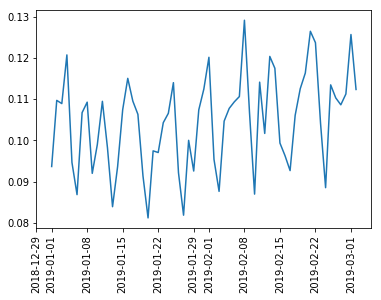

In [7]:
plt.plot(df.groupby(pd.DatetimeIndex(df['Timestamp']).normalize())['demand'].mean())
plt.xticks(rotation='vertical')

### 5.1. Graphing the points on the map

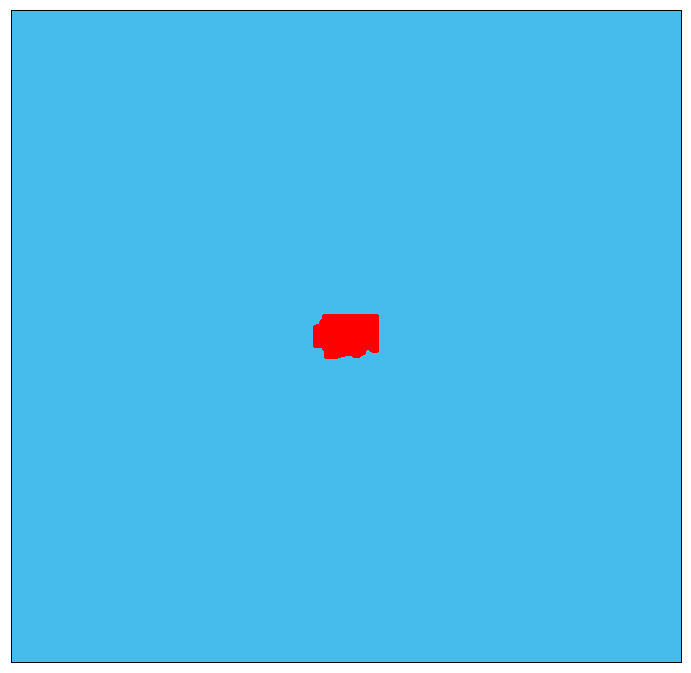

In [24]:
lat = df['latitude'].values
lon = df['longitude'].values

# determine range to print based on min, max lat and lon of the data#
margin = 2 # buffer to add to the range
lat_min = min(lat) - margin
lat_max = max(lat) + margin
lon_min = min(lon) - margin
lon_max = max(lon) + margin

# create map using BASEMAP
plt.figure(figsize=(24,12))
m = Basemap(llcrnrlon=lon_min,
            llcrnrlat=lat_min,
            urcrnrlon=lon_max,
            urcrnrlat=lat_max,
            lat_0=(lat_max - lat_min)/2,
            lon_0=(lon_max-lon_min)/2,
            projection='merc',
            resolution = 'h',
            area_thresh=10000.,
            )
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color = 'white',lake_color='#46bcec')
# convert lat and lon to map projection coordinates
lons, lats = m(lon, lat)
# plot points as red dots
m.scatter(lons, lats, marker = 'o', color='r', zorder=5)
plt.show()

## 5.2. Find hotspots

In [9]:
df_uniq = df.groupby('geohash6')['demand'].mean().sort_values(ascending=False)

df_uniq = df_uniq.reset_index()

df_uniq['lat_long'] = df_uniq.geohash6.apply(lambda x: gh.decode(x))

df_uniq['latitude'] = df_uniq.lat_long.apply(lambda x: x[0])

df_uniq['longitude'] = df_uniq.lat_long.apply(lambda x: x[1])

df_uniq.drop(columns='lat_long',inplace=True)

Text(0, 0.5, 'Longitude')

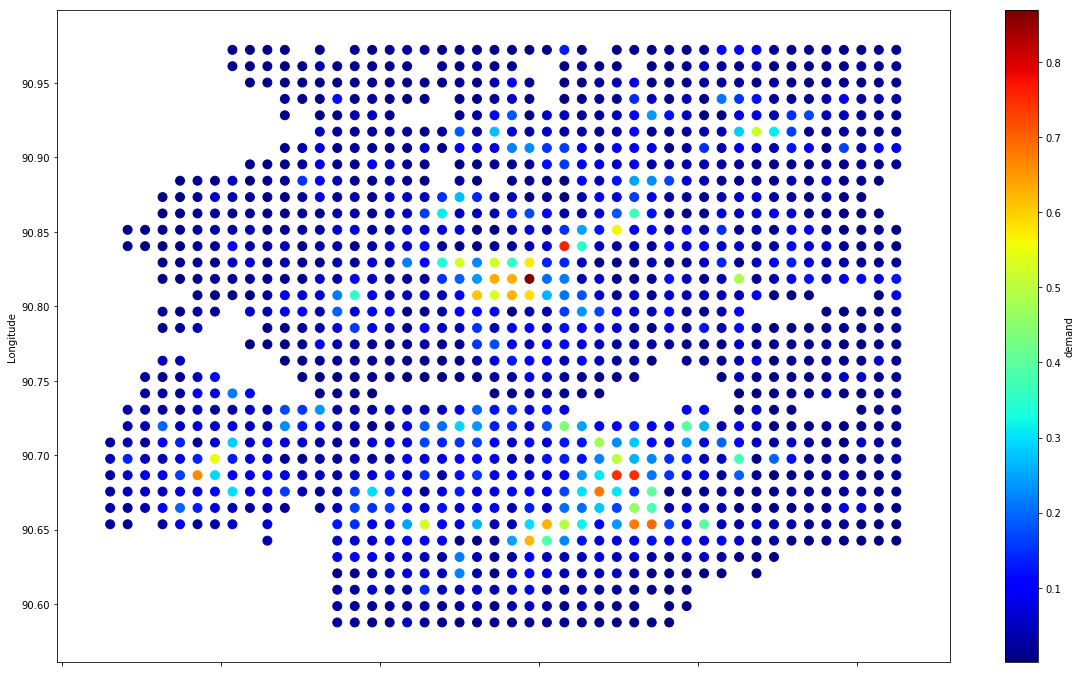

In [10]:
df_uniq.plot.scatter('latitude', 'longitude', c='demand', colormap='jet', s=80,figsize=(20,12))

plt.xlabel('Latitude')
plt.ylabel('Longitude')

In [11]:
del df_uniq

## 5.3. Animate through time

In [12]:
df_ani = df.sort_values('Timestamp')

In [13]:
df_ani = pd.pivot_table(df_ani ,values = 'demand', columns= 'geohash6', index = 'Timestamp', fill_value= 0)

In [14]:
#df_ani = df_ani.groupby(pd.DatetimeIndex(df_ani.index).normalize()).agg('mean')
df_ani = df_ani.groupby(df_ani.index.hour).agg('mean')

In [15]:
df_ani = df_ani.T

In [16]:
df_ani.reset_index(inplace = True)

df_ani['lat_long'] = df_ani.geohash6.apply(lambda x: gh.decode(x))

df_ani['latitude'] = df_ani.lat_long.apply(lambda x: x[0])

df_ani['longitude'] = df_ani.lat_long.apply(lambda x: x[1])

In [17]:
df_ani.drop(columns = ['lat_long'],inplace = True)

In [18]:
df_ani.head()

Timestamp,geohash6,0,1,2,3,4,5,6,7,8,...,16,17,18,19,20,21,22,23,latitude,longitude
0,qp02yc,0.000768,0.001400,0.004001,0.004312,0.006902,0.006680,0.006829,0.003272,0.004406,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000292,0.001037,-5.484924,90.653687
1,qp02yf,0.000070,0.000295,0.000287,0.000228,0.000126,0.000121,0.000000,0.000714,0.000581,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000128,-5.479431,90.653687
2,qp02yu,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000011,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,-5.468445,90.653687
3,qp02yv,0.000000,0.000000,0.000000,0.000000,0.000000,0.001011,0.000096,0.000000,0.001255,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,-5.462952,90.653687
4,qp02yy,0.000911,0.000432,0.000235,0.000315,0.000931,0.000519,0.000441,0.000638,0.000619,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000161,0.000128,-5.457458,90.653687


In [19]:
jet = cm.get_cmap('jet', 12)

dem_color = []
for i in range(1,25):
    dem_color.extend(jet(df_ani.iloc[:,i]))

In [ ]:
data.describe

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
%matplotlib notebook

iters = 24

# Suppose 3 fixed sensors, each with a result every day for 5 days
days = sorted(list(range(iters))*1329)
channel = (list(range(1329)))*iters
long = list(df_ani['longitude'])*iters
lat = list(df_ani['latitude'])*iters
colours = ['green', 'yellow', 'orange', 'red', 'brown']
colour = random.choices(colours, k=31896)

# create dataframe
data = pd.DataFrame(list(zip(days, channel, long, lat, colour)), columns = ['day', 'sensor', 'x', 'y', 'colour'] )
print (data)## use this to better understand what is being plotted

# Set up the plot to be animated
# I'm using ax. here, but you could also just use plt.
fig, ax = plt.subplots(figsize=(5,5))
ax.set_xlim(-6, -5)
ax.set_xlabel('Longitude',fontsize=10)
ax.set_ylim(90, 91)
ax.set_ylabel('Latitude',fontsize=10)
ax.set_title('Daily changes in Travel Demand',fontsize=10)

for i, txt in enumerate(data.sensor):
    ax.annotate(txt, xy=(data.x[i], data.y[i]), textcoords='offset points', xytext=(10,10), fontsize=20, weight='bold')

# for convenience: define a function which prepares the data
def get_data(day=0,sensor_id=0):
    x = data.loc[(data.day ==day) & (data.sensor ==sensor_id), 'x']
    y = data.loc[(data.day ==day) & (data.sensor ==sensor_id), 'y'] 
    col = data.loc[(data.day ==day) & (data.sensor ==sensor_id), 'colour']  
    return x,y,col

# initialization function 
def init(): 
    # plot the first day (day=0) here:
    for j in range(1329):
        x,y,col=get_data(day=0,sensor_id=j)
        scat = ax.scatter(x,y,c=col, s=100)
    return scat

# animation function 
def animate(i): 
    for j in range(0,1329):        
        x,y,col=get_data(day=i,sensor_id=j)
        # print(i,col)## use this to understand "where" we are
        scat = ax.scatter(x,y,c=col, s=100)

    # return plot object 
    return scat

# call the animator     
# you are iterating over day=i, so you only have 5 frames here
# also you cant use blit=True here
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=24, interval=200)

plt.show()

<IPython.core.display.Javascript object>


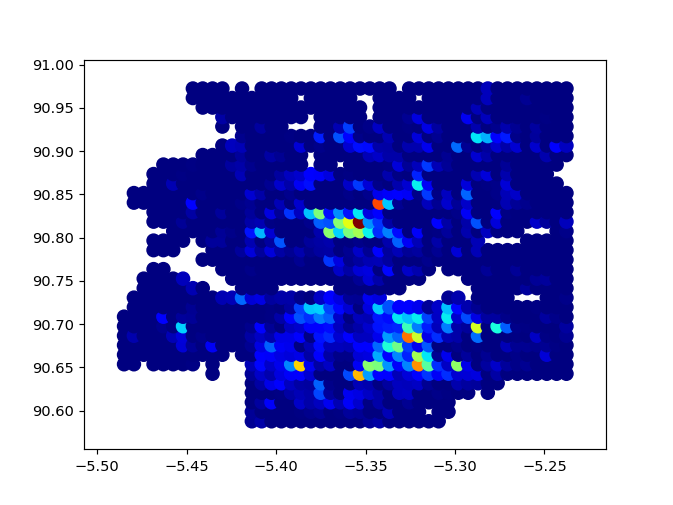

C:\Users\Acer\Anaconda\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


<IPython.core.display.Javascript object>


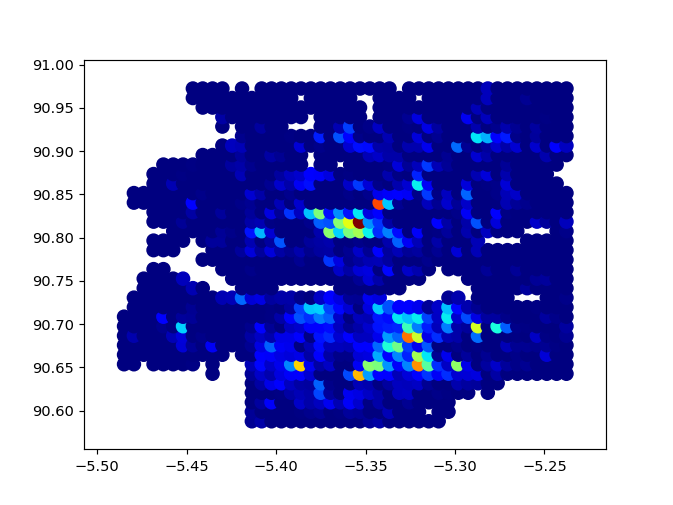

<IPython.core.display.Javascript object>


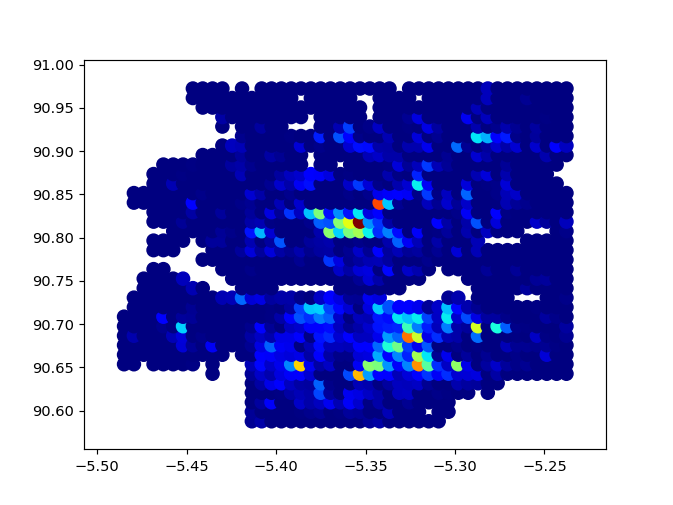

<IPython.core.display.Javascript object>


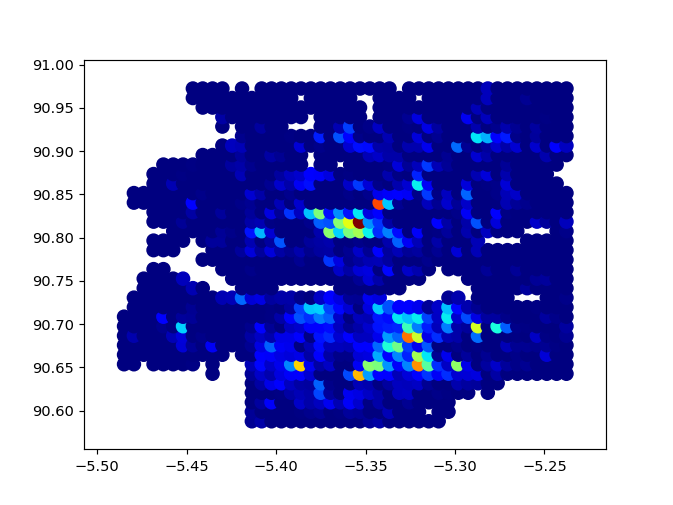

<IPython.core.display.Javascript object>


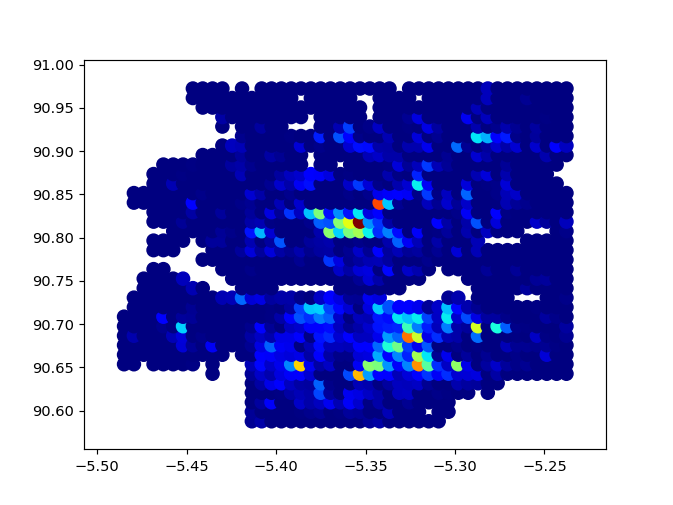

In [44]:
def GenerateColors(i):
    return df_gif.ix[:,0].to_list()

plt.ion()
for i in range(5):
    plt.figure()
    colors = GenerateColors(i)
    plt.scatter(df_gif['latitude'], df_gif['longitude'], c=colors, cmap='jet', s=80)
    plt.show(block=False)
    plt.pause(0.0001)

## 5.4. Additional EDA

### 5.4.1. Distribution of Demand

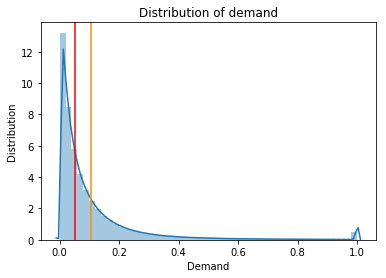

In [29]:
sns.distplot(df['demand'])
plt.title('Distribution of demand')
plt.ylabel('Distribution')
plt.xlabel('Demand')
plt.axvline(df.demand.mean(), color='darkorange')
plt.axvline(df.demand.median(), color='red')
plt.show()

### 5.4.2 Plot the average demand per day

Text(0.5, 0, 'Demand')

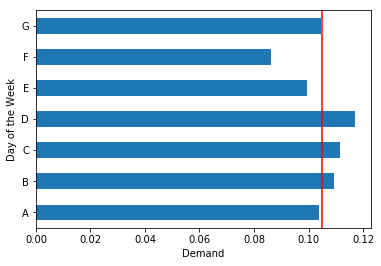

In [30]:
df.groupby('day_of_week')['demand'].mean().plot.barh()
plt.axvline(df.demand.mean(), color='red')
plt.ylabel('Day of the Week')
plt.xlabel('Demand')

## 5.5. Exploring Grab Demand Time Series Data

In [31]:
df.head()

,geohash6,demand,latitude,longitude,day_of_week,Timestamp
0,qp03wc,0.020072,-5.353088,90.653687,D,2019-01-18 20:00:00
1,qp03pn,0.024721,-5.413513,90.664673,C,2019-01-10 14:30:00
2,qp09sw,0.102821,-5.325623,90.906372,B,2019-01-09 06:15:00
3,qp0991,0.088755,-5.353088,90.752563,D,2019-02-01 05:00:00
4,qp090q,0.074468,-5.413513,90.719604,A,2019-01-15 04:00:00


In [32]:
df_stat = df.loc[df.geohash6 == 'qp09d9'].set_index('Timestamp')
df_stat.drop(columns = ['geohash6','latitude','longitude','day_of_week'],inplace=True)

In [33]:
df_stat.sort_index(inplace=True)

df_stat.head()

,demand
Timestamp,
2019-01-01 00:00:00,0.538371
2019-01-01 00:15:00,0.661457
2019-01-01 00:30:00,0.602286
2019-01-01 00:45:00,0.593089
2019-01-01 01:00:00,0.685252


### 5.5.1. Average demand for location qp09d9 for each hour of the day

Text(0.5, 0, 'Hour')

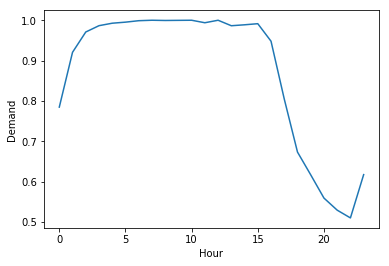

In [17]:
plt.plot(df_stat.groupby(df_stat.index.hour).mean())
plt.ylabel('Demand')
plt.xlabel('Hour')

### 5.5.2 Demand for each hour for each day at location qp09d9 

In [18]:
df_stat.reset_index(inplace=True)

In [19]:
df_stat.head()

,Timestamp,demand
0,2019-01-01 00:00:00,0.538371
1,2019-01-01 00:15:00,0.661457
2,2019-01-01 00:30:00,0.602286
3,2019-01-01 00:45:00,0.593089
4,2019-01-01 01:00:00,0.685252


Text(0.5, 0, 'Date')

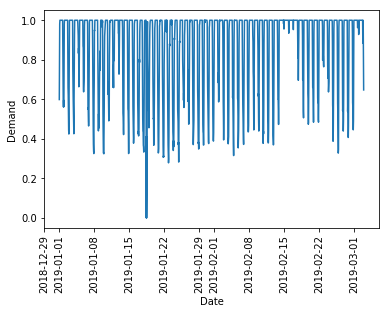

In [20]:
plt.plot(df_stat.groupby(pd.Grouper(key='Timestamp',freq='H')).mean().fillna(0))
plt.xticks(rotation='vertical')
plt.ylabel('Demand')
plt.xlabel('Date')

### 5.5.3. Average demand per hour for all locations

Text(0, 0.5, 'Demand')

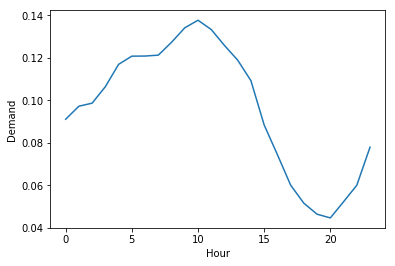

In [22]:
plt.plot(df.drop(columns=['geohash6','latitude','longitude','day_of_week']).groupby(df['Timestamp'].dt.hour).mean().fillna(0))
plt.xlabel('Hour')
plt.ylabel('Demand')

### 5.5.4 Mean demand for all locations each hour for 2 months

Text(0, 0.5, 'Demand')

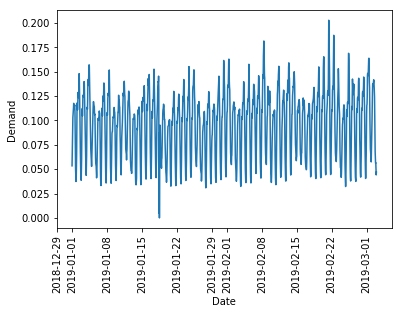

In [28]:
plt.plot(df.drop(columns=['geohash6','latitude','longitude','day_of_week']).groupby(pd.Grouper(key='Timestamp', freq='H')).mean().fillna(0))
plt.xticks(rotation='vertical')
plt.xlabel('Date')
plt.ylabel('Demand')

## 5.6. Check for Stationarity for Univariate Data

Since we will be using time series analysis, we need to check for stationarity to determine what model is appropriate for the data set. 

Although multivariate time series analysis will be used, I just wanted to the behavior of demand across the two months of data.

### 5.6.1 Visual Test

From the graph below, we see that the mean, variance, and covariance are not constant throughout time

In [31]:
df.groupby('geohash6')['demand'].mean().sort_values(ascending = False).head()

geohash6
qp09d9    0.869152
qp09e5    0.761055
qp03xx    0.753067
qp03xw    0.747082
qp03yb    0.695687
Name: demand, dtype: float64

In [32]:
df_stat = df.loc[df.geohash6 == 'qp09d9'].set_index('Timestamp')
df_stat.drop(columns = ['geohash6','latitude','longitude','day_of_week'],inplace=True)

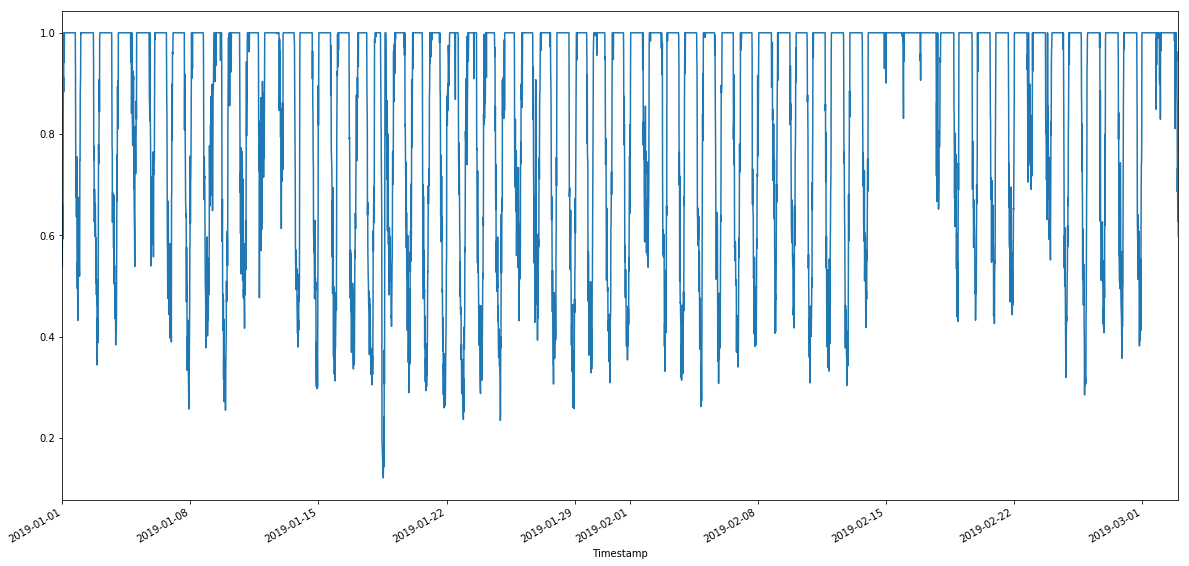

In [33]:
df_stat['demand'].plot(figsize=(20,10))

### 5.6.3. METHODS OF MAKING (UNIVARIATE) DATA STATIONARY

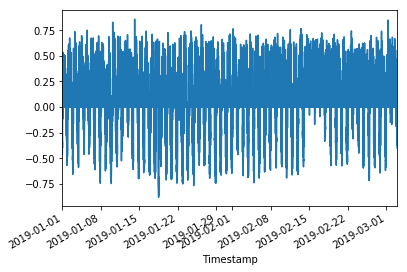

In [34]:
#Differencing
df_stat['demand_diff'] = df_stat['demand'] - df_stat['demand'].shift(1)
df_stat['demand_diff'].dropna().plot()

In [35]:
#Seasonal Differencing
n=7
df_stat['demand_diff'] = df_stat['demand'] - df_stat['demand'].shift(n)

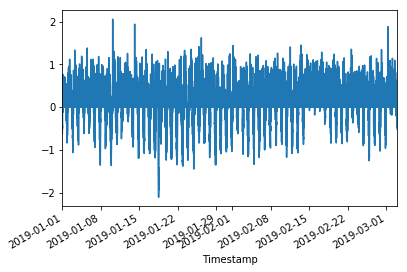

In [36]:
# Transformation
df_stat['demand_log'] = np.log(df_stat['demand'])
df_stat['demand_log_diff'] = df_stat['demand_log'] - df_stat['demand_log'].shift(1)
df_stat['demand_log_diff'].dropna().plot()

# 6. How you chose which features to use in your analysis

In [37]:
df.head()

,geohash6,demand,latitude,longitude,day_of_week,Timestamp
0,qp03wc,0.020072,-5.353088,90.653687,D,2019-01-18 20:00:00
1,qp03pn,0.024721,-5.413513,90.664673,C,2019-01-10 14:30:00
2,qp09sw,0.102821,-5.325623,90.906372,B,2019-01-09 06:15:00
3,qp0991,0.088755,-5.353088,90.752563,D,2019-02-01 05:00:00
4,qp090q,0.074468,-5.413513,90.719604,A,2019-01-15 04:00:00


# Details of your modeling process, including how you selected your models and validated them

### METHOD

1. *Try to impute the data to mean or median if zero does not work
2. Add additional features, the locations surrounding it
    <br> a. Geojson bounding box
    <br> b.
3. Make data stationary
4. Train test split
5. Create model
6. check errors

Questions

1) I'm using multivariate time series, I have read that it is necessary to transform non-stationary data to stationary data (stationary data - having constant mean, variance, and covariance throughout time) so that the model could be more generalized. 
2) 

https://towardsdatascience.com/prediction-task-with-multivariate-timeseries-and-var-model-47003f629f9
https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/
important
https://machinelearningmastery.com/how-to-develop-machine-learning-models-for-multivariate-multi-step-air-pollution-time-series-forecasting/

# 7. SARIMAX METHOD

Looking at the average demand for the whole location instead of each location

## 7.1. Data Preparation

In [2]:
df = pd.read_csv('Processed_Grab.csv')

df.Timestamp = df.Timestamp.apply(lambda x: pd.Timestamp(x))

df.drop(columns = ['Unnamed: 0'],inplace = True)

df.head()

,geohash6,demand,latitude,longitude,day_of_week,Timestamp
0,qp03wc,0.020072,-5.353088,90.653687,D,2019-01-18 20:00:00
1,qp03pn,0.024721,-5.413513,90.664673,C,2019-01-10 14:30:00
2,qp09sw,0.102821,-5.325623,90.906372,B,2019-01-09 06:15:00
3,qp0991,0.088755,-5.353088,90.752563,D,2019-02-01 05:00:00
4,qp090q,0.074468,-5.413513,90.719604,A,2019-01-15 04:00:00


In [3]:
df_S = pd.pivot_table(df ,values = 'demand', index = ['Timestamp'], columns = ['geohash6'],fill_value=0)

In [4]:
df_S.head()

geohash6,qp02yc,qp02yf,qp02yu,qp02yv,qp02yy,qp02yz,qp02z1,qp02z3,qp02z4,qp02z5,...,qp0djv,qp0djw,qp0djy,qp0dn0,qp0dn1,qp0dn4,qp0dn5,qp0dnh,qp0dnj,qp0dnn
Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2019-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0006,...,0.0,0.0,0.004056,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2019-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.009381,0.0
2019-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2019-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.008253,0.0,0.0,0.0,0.0,0.0,0.002701,0.0


In [5]:
df_S['demand'] = df_S.loc[:,'qp02yc':'qp0dnn'].mean(axis=1)

df_S.drop(columns =  df_S.loc[:,'qp02yc':'qp0dnn'].columns,inplace=True)

In [6]:
df_S.head()

geohash6,demand
Timestamp,
2019-01-01 00:00:00,0.022744
2019-01-01 00:15:00,0.025120
2019-01-01 00:30:00,0.027232
2019-01-01 00:45:00,0.029258
2019-01-01 01:00:00,0.033303


In [7]:
df_S.sort_index(inplace=True)

df_S.head()

geohash6,demand
Timestamp,
2019-01-01 00:00:00,0.022744
2019-01-01 00:15:00,0.025120
2019-01-01 00:30:00,0.027232
2019-01-01 00:45:00,0.029258
2019-01-01 01:00:00,0.033303


## 7.2. Exploring the data

### 7.2.1. Monthly Trends

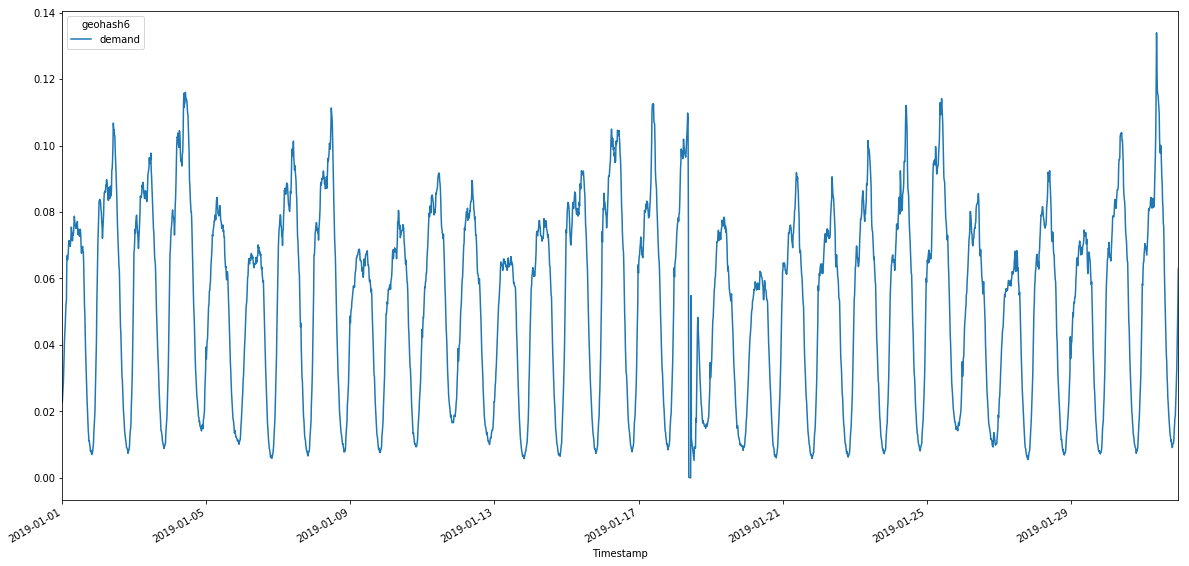

In [8]:
df_S['2019-01'].plot(figsize=(20,10))

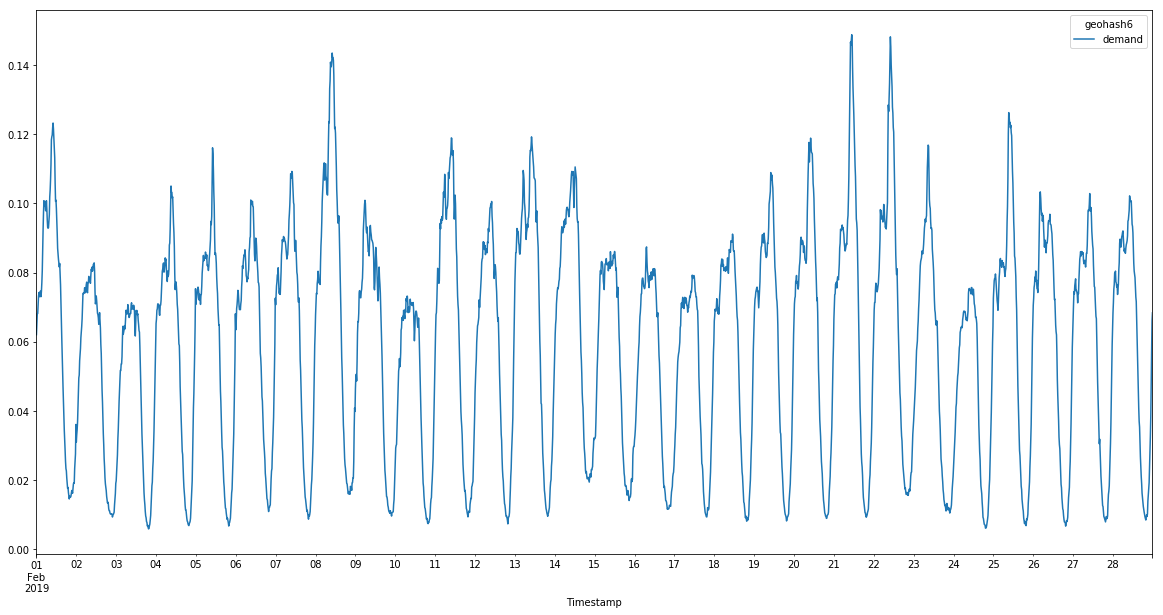

In [9]:
df_S['2019-02'].plot(figsize=(20,10))

### 7.2.2. Average Hourly demand for Day of the Week

In [10]:
df_day = pd.pivot_table(df ,values = 'demand', index = ['geohash6','day_of_week'], columns = ['Timestamp'],fill_value=0).reset_index()

df_day = df_day.groupby('day_of_week').aggregate('mean')

df_day = df_day.T

df_day.reset_index(inplace=True)

df_day = df_day.groupby(df_day['Timestamp'].dt.hour).mean()

In [11]:
df_day.head()

day_of_week,A,B,C,D,E,F,G
Timestamp,,,,,,,
0,0.009138,0.010529,0.009978,0.009382,0.005853,0.003543,0.008902
1,0.010129,0.011449,0.010892,0.010554,0.007545,0.005100,0.009573
2,0.010201,0.010994,0.010668,0.010940,0.009060,0.006579,0.009289
3,0.011062,0.011584,0.011404,0.012146,0.010446,0.007571,0.010128
4,0.012411,0.012773,0.012621,0.014313,0.011747,0.008517,0.011093


In [12]:
from matplotlib.lines import Line2D

def plot_days(ts_w):
    
    plt.figure(figsize=(10,5))
        
    for wd in range(0, 7):
        x_vals = ts_w.index
        y_vals = ts_w.iloc[:,[wd]]
        
        plt.plot(x_vals, y_vals, lw=3, label=wd)
        
    plt.legend(['A','B','C','D','E','F','G'], loc=2)
    plt.xlabel('Hour')
    plt.xticks(x_vals, x_vals)
    plt.xlim((0, 23))
    plt.ylim(ymin=0)

C:\Users\Acer\Anaconda\lib\site-packages\matplotlib\axes\_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


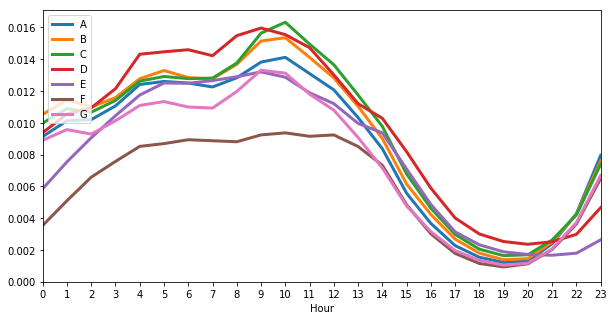

In [13]:
plot_days(df_day)

### 7.2.3. Random Day

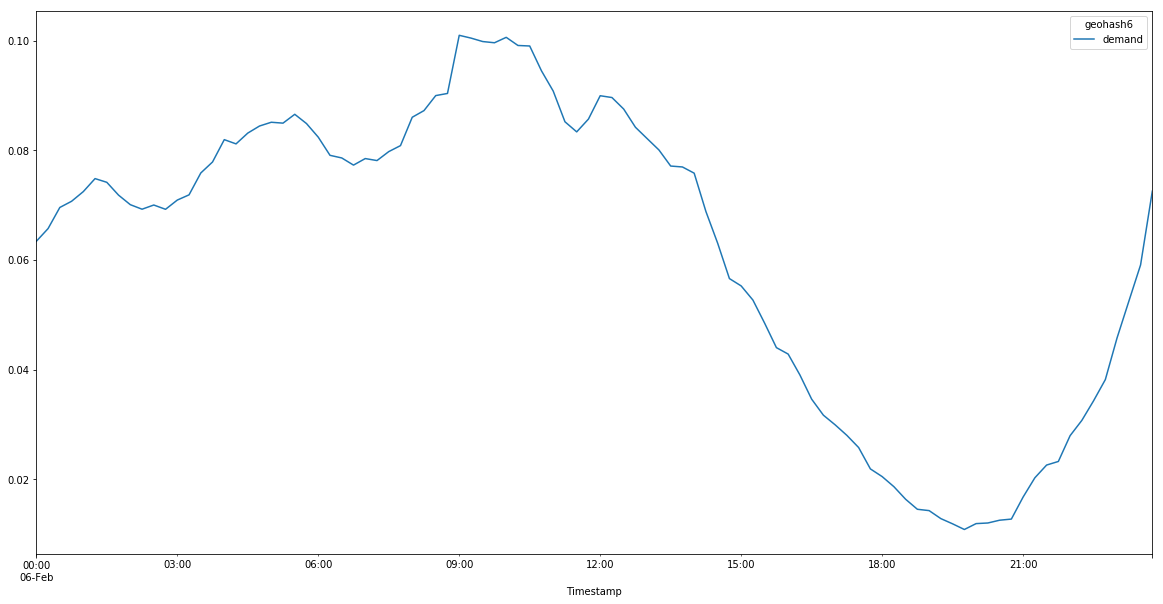

In [20]:
df_S['2019-02-06'].plot(figsize=(20,10))

## 7.3. Train Test Split

In [8]:
df_S_train = df_S[:'2019-02-19']
df_S_test = df_S['2019-02-20':]

In [9]:
df_S_train.head()

geohash6,demand
Timestamp,
2019-01-01 00:00:00,0.022744
2019-01-01 00:15:00,0.025120
2019-01-01 00:30:00,0.027232
2019-01-01 00:45:00,0.029258
2019-01-01 01:00:00,0.033303


In [10]:
df_S_test.head()

geohash6,demand
Timestamp,
2019-02-20 00:00:00,0.066160
2019-02-20 00:15:00,0.070937
2019-02-20 00:30:00,0.072564
2019-02-20 00:45:00,0.073076
2019-02-20 01:00:00,0.077409


## 7.4 Test for Stationarity

To create a time series model, the data must be stationary (e.i. there is constant mean, variance and covariance)

In [17]:
# adapted from https://www.analyticsvidhya.com/blog/2016
# /02/time-series-forecasting-codes-python/

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, rolling=96):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window = rolling).mean()
    rolstd = timeseries.rolling(window = rolling).std()

    #Plot rolling statistics:
    plt.figure(figsize=(20,10))
    orig = plt.plot(timeseries, color='darkgray',label='Original')
    mean = plt.plot(rolmean, color='darkblue', label='Rolling Mean', lw=1)
    std = plt.plot(rolstd, color='red', label = 'Rolling Std', lw=1)
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.ylabel('Differenced # of Uber Pickups\nx(t) - x(t-1)')
    plt.xlim(timeseries.index.min(), timeseries.index.max())
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    result = adfuller(timeseries)
    print('> ADF Statistic: {:.3f}'.format(result[0]))
    print('> p-value: {:.3e}'.format(result[1]))
    print('> Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

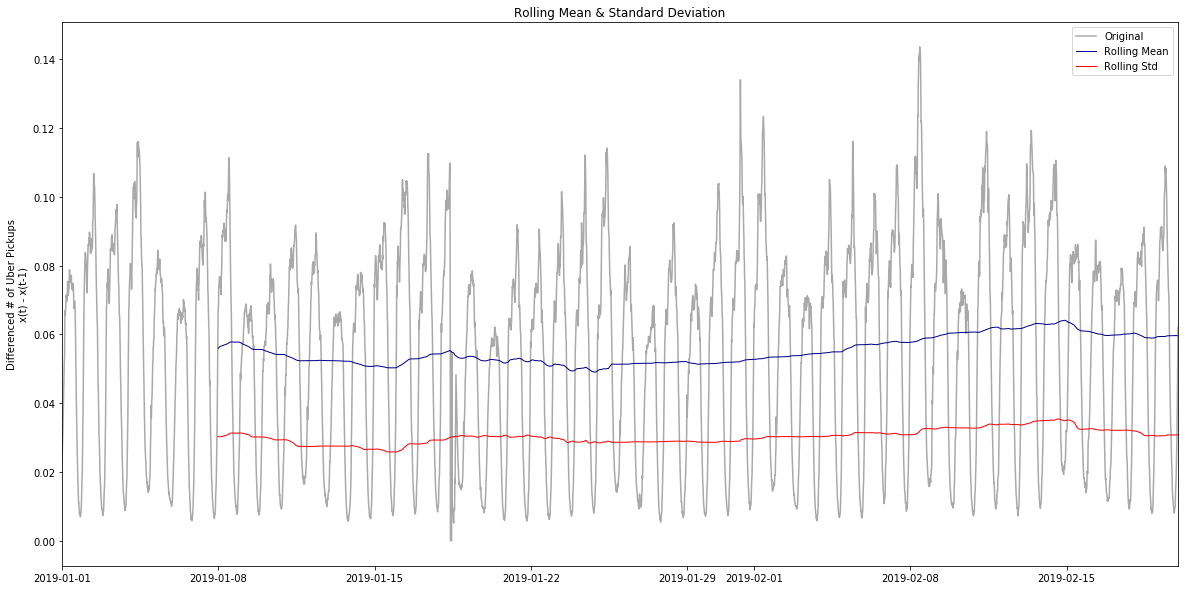

Results of Dickey-Fuller Test:
> ADF Statistic: -13.965
> p-value: 4.442e-26
> Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [18]:
test_stationarity(df_S_train.demand, rolling=672)

### 7.4.1. Differencing the time series

#### 1st order differencing

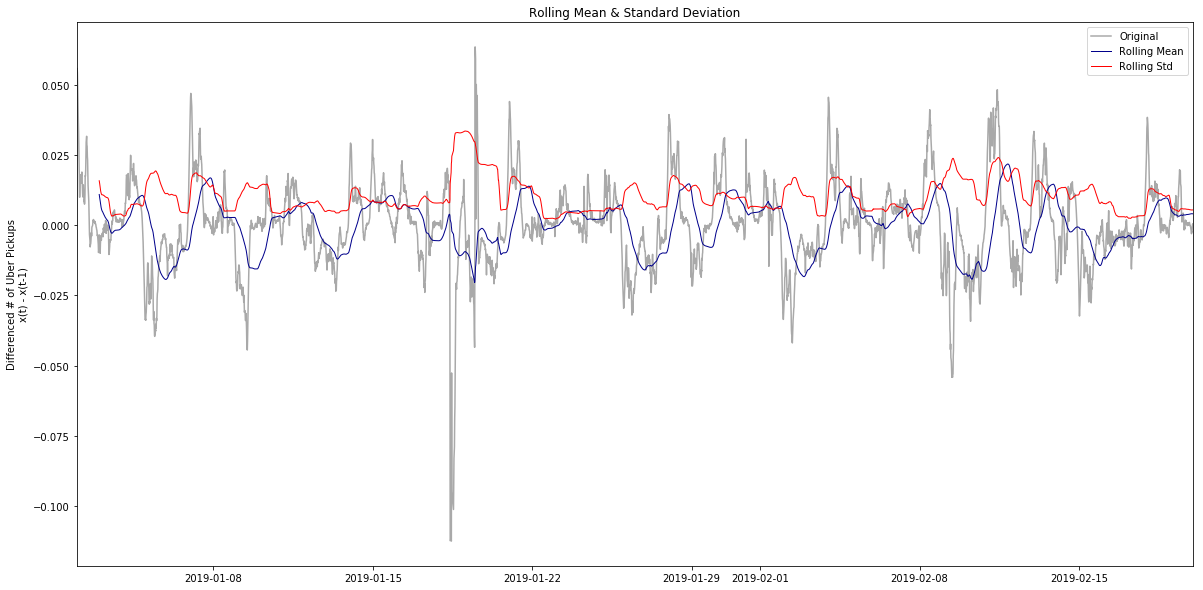

Results of Dickey-Fuller Test:
> ADF Statistic: -8.558
> p-value: 8.866e-14
> Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [19]:
# create a first-order differenced timeseries by
# subtracting the previous hour's value and
# removing the resulting n/a for the first value

diff = df_S_train.demand-df_S_train.demand.shift(96)
diff.dropna(inplace=True)

test_stationarity(diff)

#### 1st order + Seasonal Differencing

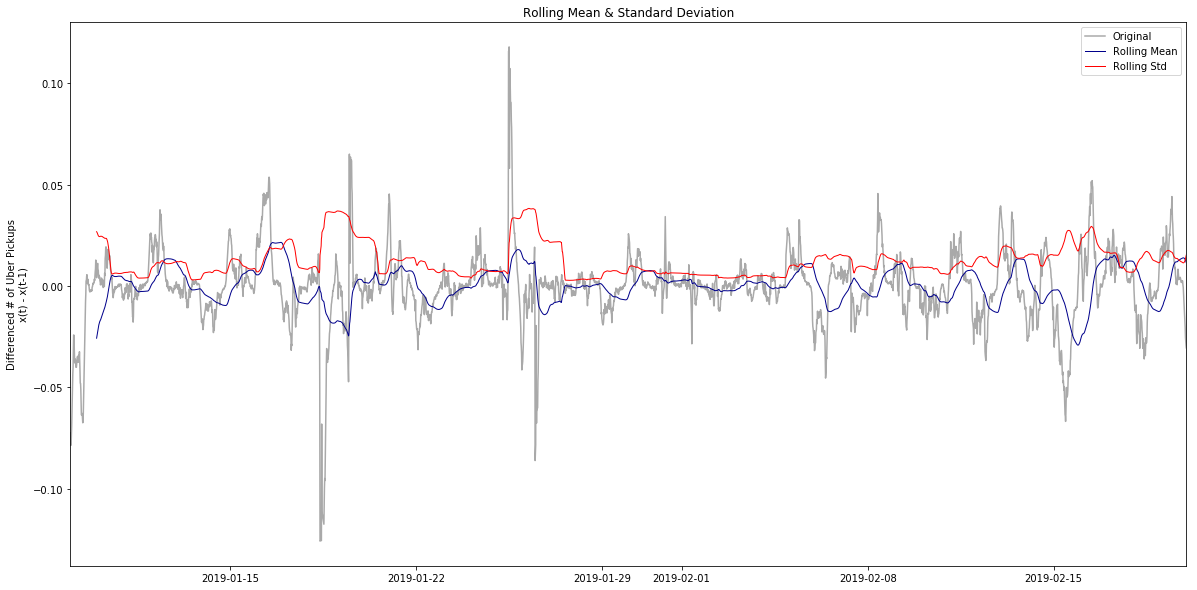

Results of Dickey-Fuller Test:
> ADF Statistic: -8.782
> p-value: 2.366e-14
> Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [20]:
diff = diff-diff.shift(672)
diff.dropna(inplace=True)

test_stationarity(diff)

## 7.5. Seasonal Decompose

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

### 7.5.1. Daily Seasonal Decompose

<Figure size 432x288 with 0 Axes>

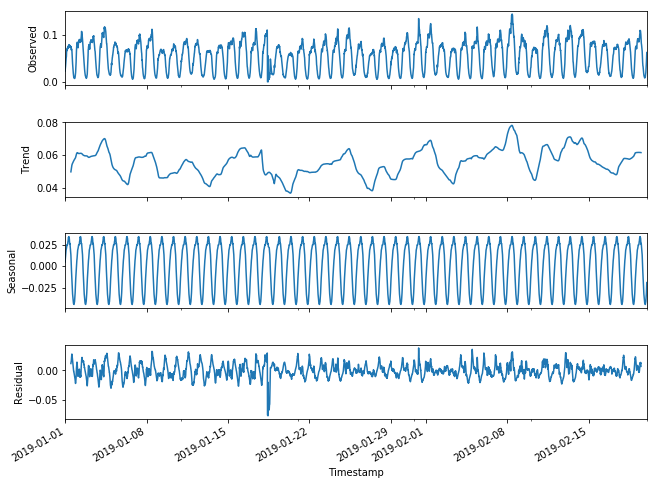

In [22]:
## Frequency derived from (24*60)min per day /15 min intervals
f = len(df_S['2019-01-01'])

decomposition = seasonal_decompose(df_S_train, freq=f)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(10, 8)



### 7.5.2. Weekly Seasonal Decompose

<Figure size 432x288 with 0 Axes>

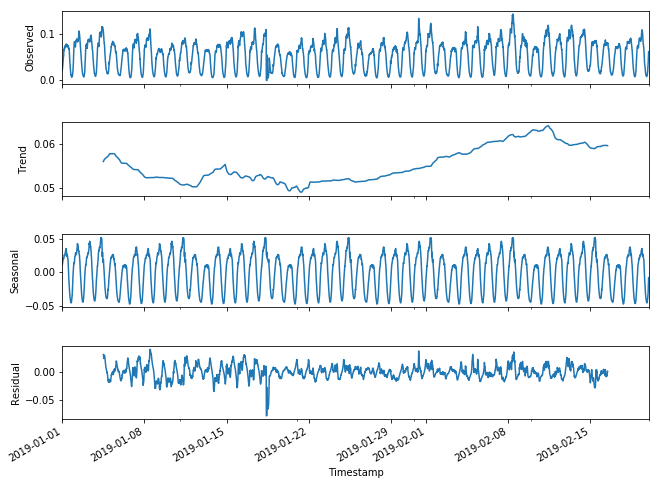

In [23]:
## Frequency derived from (24*60)min per day /15 min intervals * 7 days
f = len(df_S['2019-01-01':'2019-01-07'])
decomposition = seasonal_decompose(df_S_train, freq=f)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(10, 8)

## 7.6. Auto-Correlation Plots

Number of lags: 1344 (14.00 days)


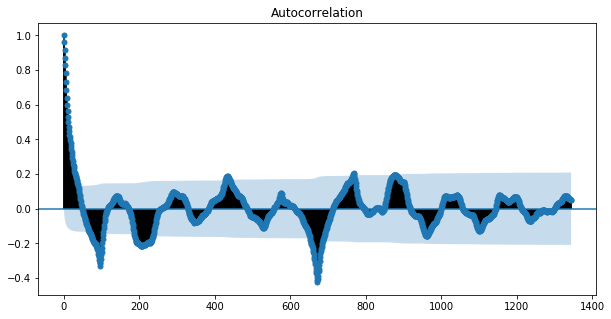

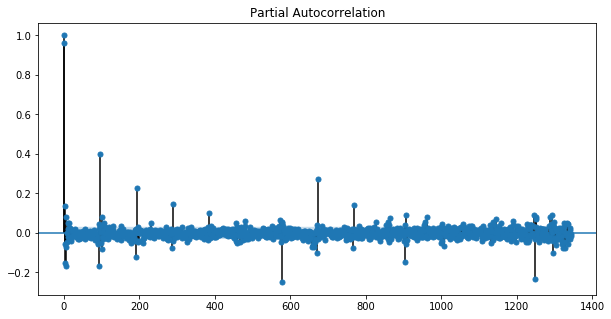

In [24]:
from statsmodels.graphics.tsaplots import plot_acf,  plot_pacf

lags_to_show = 672*2
print('Number of lags: {} ({:.2f} days)'.format(lags_to_show, 
                                                lags_to_show/96))

# plot autocorrelation 
fig, ax = plt.subplots(figsize=(10,5))
plot_acf(diff, ax = ax, lags=lags_to_show);

# plot PACF
fig, ax = plt.subplots(figsize=(10,5))
plot_pacf(diff, ax = ax, lags=lags_to_show);

## 7.7. Creating SARIMAX Model

In [11]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(y_actual, y_predicted, print_val=True):
    """
    Args:
    -----
    y_actual - Array of actual target values
    y_predicted - Array of predicted target values
    print_val - If `True` (default), RMSE will be
                printed. Otherwise, it will be 
                returned.
    """
    err = sqrt(mean_squared_error(y_actual, y_predicted))
    if print_val:
        print('RMSE: {:,.2f}'.format(err))
    else:
        return err
    
    
def plot_forecast(actual, pred, title='Actual vs Forecast', 
                  xlabel='Date', ylabel='Demand', 
                  grid=True, figsize=(10, 5)):
    
    if len(actual) != len(pred):
        return_str = 'Unequal lengths error: '
        return_str += '({} actual, '.format(len(actual))
        return_str += '{} forecast)'.format(len(pred))
        return return_str
    
    plt.figure(figsize=figsize)
    plt.plot(actual, label='Actual')
    plt.plot(actual.index, pred, label='Predicted', c='r')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    #plt.xticks(actual.index.date[::24], actual.index.day[::24])
    plt.xlim(min(actual.index.date), max(actual.index.date))
    plt.legend(loc=0)
    plt.grid(True)

In [ ]:
# create SARIMAX model with previously determined lags

from statsmodels.tsa.statespace import sarimax

sar_m = sarimax.SARIMAX(df_S_train.values,
                        trend='n', 
                        order=(2,1,1), 
                        seasonal_order=(2, 1, 1, 24), 
                        simple_differencing=False).fit()

In [ ]:
# forecast = results.predict(start = 168, end = 191)
predict_steps = 96*11
forecast = sar_m.forecast(steps=predict_steps)

# plot against real data
plot_forecast(df_S_test[:predict_steps], forecast, 
              title='SARIMAX - Predicted vs Actual', 
              xlabel='Date', 
              ylabel='Demand')


In [ ]:
# calculate RMSE error
rmse(df_S_test[:predict_steps].demand, forecast)

# 8. Using Facebook Prophet

In [ ]:
!pip install fbprophet

In [ ]:
from fbprophet import Prophet



# 8. Forecasting Demand in each Location using Multivariate Time Series Analysis by Applying VAR

## 8.1. Data Preparation

### 8.1.1 Pivot table to access locations

In [159]:
df.head()

,geohash6,demand,latitude,longitude,day_of_week,Timestamp
0,qp03wc,0.020072,-5.353088,90.653687,D,2019-01-18 20:00:00
1,qp03pn,0.024721,-5.413513,90.664673,C,2019-01-10 14:30:00
2,qp09sw,0.102821,-5.325623,90.906372,B,2019-01-09 06:15:00
3,qp0991,0.088755,-5.353088,90.752563,D,2019-02-01 05:00:00
4,qp090q,0.074468,-5.413513,90.719604,A,2019-01-15 04:00:00


In [160]:
df_final=pd.pivot_table(df ,values = 'demand', index = ['geohash6'], columns = ['Timestamp'],fill_value=0)

df_final.reset_index(inplace=True)

df_final['lat_long'] = df_final.geohash6.apply(lambda x: gh.decode(x))

In [161]:
df_final.head()

Timestamp,geohash6,2019-01-01 00:00:00,2019-01-01 00:15:00,2019-01-01 00:30:00,2019-01-01 00:45:00,2019-01-01 01:00:00,2019-01-01 01:15:00,2019-01-01 01:30:00,2019-01-01 01:45:00,2019-01-01 02:00:00,...,2019-03-02 21:45:00,2019-03-02 22:00:00,2019-03-02 22:15:00,2019-03-02 22:30:00,2019-03-02 22:45:00,2019-03-02 23:00:00,2019-03-02 23:15:00,2019-03-02 23:30:00,2019-03-02 23:45:00,lat_long
0,qp02yc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(-5.48492431640625, 90.6536865234375)"
1,qp02yf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(-5.47943115234375, 90.6536865234375)"
2,qp02yu,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(-5.46844482421875, 90.6536865234375)"
3,qp02yv,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(-5.46295166015625, 90.6536865234375)"
4,qp02yy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(-5.45745849609375, 90.6536865234375)"


In [162]:
#Shortest distance between points
lat_dist = 0.0054931640625
#df_final['lat_long'][19][0]-df_final['lat_long'][18][0]
long_dist = 0.010986328125
#df_final['lat_long'][19][1]-df_final['lat_long'][3][1]

#Define function to find closest points
def closest_points(loc_array,location,n):
    points = []
    for i in loc_array:
        if (abs(i[0]-location[0])<=(n*lat_dist) and abs(i[1]-location[1])<=(n*long_dist)
            and (abs(i[1]-location[1])+abs(i[0]-location[0]))!=0):
            points.append(i)
    return points

In [163]:
#Setting n_1 and and n_2 closest locations
df_final['n1'] = df_final.lat_long.apply(lambda x: closest_points(df_final.lat_long,x,1))
df_final['n2'] = df_final.lat_long.apply(lambda x: list(set(closest_points(df_final.lat_long,x,2)) - set(closest_points(df_final.lat_long,x,1))))

In [164]:
df_final.head()

Timestamp,geohash6,2019-01-01 00:00:00,2019-01-01 00:15:00,2019-01-01 00:30:00,2019-01-01 00:45:00,2019-01-01 01:00:00,2019-01-01 01:15:00,2019-01-01 01:30:00,2019-01-01 01:45:00,2019-01-01 02:00:00,...,2019-03-02 22:15:00,2019-03-02 22:30:00,2019-03-02 22:45:00,2019-03-02 23:00:00,2019-03-02 23:15:00,2019-03-02 23:30:00,2019-03-02 23:45:00,lat_long,n1,n2
0,qp02yc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(-5.48492431640625, 90.6536865234375)","[(-5.47943115234375, 90.6536865234375), (-5.48...","[(-5.47393798828125, 90.6646728515625), (-5.48..."
1,qp02yf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(-5.47943115234375, 90.6536865234375)","[(-5.48492431640625, 90.6536865234375), (-5.48...","[(-5.48492431640625, 90.6756591796875), (-5.46..."
2,qp02yu,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(-5.46844482421875, 90.6536865234375)","[(-5.46295166015625, 90.6536865234375), (-5.47...","[(-5.45745849609375, 90.6536865234375), (-5.47..."
3,qp02yv,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(-5.46295166015625, 90.6536865234375)","[(-5.46844482421875, 90.6536865234375), (-5.45...","[(-5.47393798828125, 90.6646728515625), (-5.45..."
4,qp02yy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(-5.45745849609375, 90.6536865234375)","[(-5.46295166015625, 90.6536865234375), (-5.45...","[(-5.46844482421875, 90.6646728515625), (-5.46..."


### 7.1.2  Find the n=1 layer away from central point and aggregate the demand

In [167]:
df_n1 = pd.DataFrame(columns=df_final.columns)

df_n1.drop(columns = ['n1','n2','geohash6'],inplace=True)

labels = []
for x in range(0,len(df_final.n1)):
    l = str(df_final.lat_long[x]) + '_1'
    labels.append(l)
    df_n1 = df_n1.append(df_final.loc[df_final.lat_long.isin(df_final.n1[x])].iloc[:,1:5848].agg('mean'),ignore_index = True)

df_n1['lat_long']=labels

In [168]:
df_n1.head()

Timestamp,2019-01-01 00:00:00,2019-01-01 00:15:00,2019-01-01 00:30:00,2019-01-01 00:45:00,2019-01-01 01:00:00,2019-01-01 01:15:00,2019-01-01 01:30:00,2019-01-01 01:45:00,2019-01-01 02:00:00,2019-01-01 02:15:00,...,2019-03-02 21:45:00,2019-03-02 22:00:00,2019-03-02 22:15:00,2019-03-02 22:30:00,2019-03-02 22:45:00,2019-03-02 23:00:00,2019-03-02 23:15:00,2019-03-02 23:30:00,2019-03-02 23:45:00,lat_long
0,0.0,0.00000,0.0,0.000000,0.0,0.00000,0.033106,0.000000,0.009938,0.033330,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,"(-5.48492431640625, 90.6536865234375)_1"
1,0.0,0.00015,0.0,0.000000,0.0,0.00000,0.024829,0.000000,0.007453,0.024998,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,"(-5.47943115234375, 90.6536865234375)_1"
2,0.0,0.00015,0.0,0.002135,0.0,0.00000,0.000000,0.000000,0.020592,0.062940,...,0.0,0.0,0.0,0.0,0.0,0.000789,0.0,0.0,0.0,"(-5.46844482421875, 90.6536865234375)_1"
3,0.0,0.00000,0.0,0.001708,0.0,0.01215,0.015134,0.015997,0.020886,0.075173,...,0.0,0.0,0.0,0.0,0.0,0.000631,0.0,0.0,0.0,"(-5.46295166015625, 90.6536865234375)_1"
4,0.0,0.00000,0.0,0.000000,0.0,0.01215,0.015260,0.027161,0.028184,0.080079,...,0.0,0.0,0.0,0.0,0.0,0.000631,0.0,0.0,0.0,"(-5.45745849609375, 90.6536865234375)_1"


### 7.1.3  Find the n=2 layers away from central point and aggregate the demand

In [169]:
df_n2 = pd.DataFrame(columns=df_final.columns)

df_n2.drop(columns = ['n1','n2','geohash6'],inplace=True)

df_n2.head()

labels_2 = []
for x in range(0,len(df_final.n2)):
    l = str(df_final.lat_long[x]) + '_2'
    labels_2.append(l)
    df_n2 = df_n2.append(df_final.loc[df_final.lat_long.isin(df_final.n2[x])].iloc[:,1:5848].agg('mean'),ignore_index = True)

df_n2['lat_long']=labels_2

df_n2.head()

Timestamp,2019-01-01 00:00:00,2019-01-01 00:15:00,2019-01-01 00:30:00,2019-01-01 00:45:00,2019-01-01 01:00:00,2019-01-01 01:15:00,2019-01-01 01:30:00,2019-01-01 01:45:00,2019-01-01 02:00:00,2019-01-01 02:15:00,...,2019-03-02 21:45:00,2019-03-02 22:00:00,2019-03-02 22:15:00,2019-03-02 22:30:00,2019-03-02 22:45:00,2019-03-02 23:00:00,2019-03-02 23:15:00,2019-03-02 23:30:00,2019-03-02 23:45:00,lat_long
0,0.000000,0.000150,0.000000,0.000000,0.000000,0.000000,0.000000,0.002964,0.000000,0.004904,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,"(-5.48492431640625, 90.6536865234375)_2"
1,0.000000,0.000000,0.000000,0.001424,0.008168,0.000000,0.000000,0.005150,0.000000,0.005615,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,"(-5.47943115234375, 90.6536865234375)_2"
2,0.000000,0.000000,0.000000,0.000000,0.010731,0.006750,0.027379,0.024350,0.006010,0.020710,...,0.000891,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000359,0.000741,"(-5.46844482421875, 90.6536865234375)_2"
3,0.005256,0.000968,0.000000,0.007560,0.013270,0.000000,0.030107,0.035205,0.017124,0.023773,...,0.001002,0.0,0.0,0.0,0.0,0.000171,0.002861,0.000403,0.015984,"(-5.46295166015625, 90.6536865234375)_2"
4,0.006378,0.000794,0.000514,0.014985,0.014753,0.010846,0.044821,0.031938,0.046688,0.054717,...,0.000891,0.0,0.0,0.0,0.0,0.000164,0.002543,0.000359,0.017799,"(-5.45745849609375, 90.6536865234375)_2"


### 7.1.4. Concatenate df_final and df_n1 and df_n2

In [170]:
df_final.head()

Timestamp,geohash6,2019-01-01 00:00:00,2019-01-01 00:15:00,2019-01-01 00:30:00,2019-01-01 00:45:00,2019-01-01 01:00:00,2019-01-01 01:15:00,2019-01-01 01:30:00,2019-01-01 01:45:00,2019-01-01 02:00:00,...,2019-03-02 22:15:00,2019-03-02 22:30:00,2019-03-02 22:45:00,2019-03-02 23:00:00,2019-03-02 23:15:00,2019-03-02 23:30:00,2019-03-02 23:45:00,lat_long,n1,n2
0,qp02yc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(-5.48492431640625, 90.6536865234375)","[(-5.47943115234375, 90.6536865234375), (-5.48...","[(-5.47393798828125, 90.6646728515625), (-5.48..."
1,qp02yf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(-5.47943115234375, 90.6536865234375)","[(-5.48492431640625, 90.6536865234375), (-5.48...","[(-5.48492431640625, 90.6756591796875), (-5.46..."
2,qp02yu,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(-5.46844482421875, 90.6536865234375)","[(-5.46295166015625, 90.6536865234375), (-5.47...","[(-5.45745849609375, 90.6536865234375), (-5.47..."
3,qp02yv,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(-5.46295166015625, 90.6536865234375)","[(-5.46844482421875, 90.6536865234375), (-5.45...","[(-5.47393798828125, 90.6646728515625), (-5.45..."
4,qp02yy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(-5.45745849609375, 90.6536865234375)","[(-5.46295166015625, 90.6536865234375), (-5.45...","[(-5.46844482421875, 90.6646728515625), (-5.46..."


In [171]:
df_multi = pd.concat([df_final,df_n1])
df_multi = pd.concat([df_multi,df_n2])

df_multi.drop(columns=['geohash6','n1','n2'],inplace=True)

C:\Users\Acer\Anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.
C:\Users\Acer\Anaconda\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [172]:
df_multi.head()

,2019-01-01 00:00:00,2019-01-01 00:15:00,2019-01-01 00:30:00,2019-01-01 00:45:00,2019-01-01 01:00:00,2019-01-01 01:15:00,2019-01-01 01:30:00,2019-01-01 01:45:00,2019-01-01 02:00:00,2019-01-01 02:15:00,...,2019-03-02 21:45:00,2019-03-02 22:00:00,2019-03-02 22:15:00,2019-03-02 22:30:00,2019-03-02 22:45:00,2019-03-02 23:00:00,2019-03-02 23:15:00,2019-03-02 23:30:00,2019-03-02 23:45:00,lat_long
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(-5.48492431640625, 90.6536865234375)"
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(-5.47943115234375, 90.6536865234375)"
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(-5.46844482421875, 90.6536865234375)"
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(-5.46295166015625, 90.6536865234375)"
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(-5.45745849609375, 90.6536865234375)"


In [173]:
df_multi.set_index('lat_long',inplace=True)

df_multi = df_multi.T

df_multi.reset_index(inplace=True)

df_multi.rename(columns={'index':'Timestamp'},inplace=True)

In [174]:
df_multi.set_index('Timestamp',inplace=True)

df_multi.head()

lat_long,"(-5.48492431640625, 90.6536865234375)","(-5.47943115234375, 90.6536865234375)","(-5.46844482421875, 90.6536865234375)","(-5.46295166015625, 90.6536865234375)","(-5.45745849609375, 90.6536865234375)","(-5.45196533203125, 90.6536865234375)","(-5.48492431640625, 90.6646728515625)","(-5.48492431640625, 90.6756591796875)","(-5.47943115234375, 90.6646728515625)","(-5.47393798828125, 90.6646728515625)",...,"(-5.24322509765625, 90.9613037109375)_2","(-5.23773193359375, 90.9503173828125)_2","(-5.23773193359375, 90.9613037109375)_2","(-5.27069091796875, 90.9722900390625)_2","(-5.26519775390625, 90.9722900390625)_2","(-5.25970458984375, 90.9722900390625)_2","(-5.25421142578125, 90.9722900390625)_2","(-5.24871826171875, 90.9722900390625)_2","(-5.24322509765625, 90.9722900390625)_2","(-5.23773193359375, 90.9722900390625)_2"
Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.000668,0.000405,0.000607,0.007307,0.000000,0.000000,0.000000,0.001054,0.0,0.0
2019-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0006,...,0.000351,0.000418,0.000409,0.011079,0.001429,0.001429,0.001429,0.001880,0.0,0.0
2019-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.001010,0.003283,0.000084,0.006588,0.001864,0.000546,0.001588,0.000546,0.0,0.0
2019-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.002330,0.000139,0.000000,0.010138,0.002481,0.000000,0.000000,0.000000,0.0,0.0
2019-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.015558,0.001376,0.010361,0.007300,0.000000,0.000000,0.000300,0.000917,0.0,0.0


### 7.1.5 Make dataframe for univariate data

In [176]:
df_uni = df_multi[df_multi.columns.drop(list(df_multi.filter(regex='_')))]

In [178]:
df_uni

lat_long,"(-5.48492431640625, 90.6536865234375)","(-5.47943115234375, 90.6536865234375)","(-5.46844482421875, 90.6536865234375)","(-5.46295166015625, 90.6536865234375)","(-5.45745849609375, 90.6536865234375)","(-5.45196533203125, 90.6536865234375)","(-5.48492431640625, 90.6646728515625)","(-5.48492431640625, 90.6756591796875)","(-5.47943115234375, 90.6646728515625)","(-5.47393798828125, 90.6646728515625)",...,"(-5.24322509765625, 90.9613037109375)","(-5.23773193359375, 90.9503173828125)","(-5.23773193359375, 90.9613037109375)","(-5.27069091796875, 90.9722900390625)","(-5.26519775390625, 90.9722900390625)","(-5.25970458984375, 90.9722900390625)","(-5.25421142578125, 90.9722900390625)","(-5.24871826171875, 90.9722900390625)","(-5.24322509765625, 90.9722900390625)","(-5.23773193359375, 90.9722900390625)"
Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.00000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2019-01-01 00:15:00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.00000,0.000600,...,0.0,0.000000,0.004056,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2019-01-01 00:30:00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.00000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.009381,0.0
2019-01-01 00:45:00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.00000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2019-01-01 01:00:00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.00000,0.000000,...,0.0,0.000000,0.008253,0.0,0.000000,0.0,0.0,0.0,0.002701,0.0
2019-01-01 01:15:00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.00000,0.000000,...,0.0,0.000000,0.006971,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2019-01-01 01:30:00,0.000000,0.0,0.0,0.0,0.000000,0.000000,9.931735e-02,0.0,0.00000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.019563,0.0
2019-01-01 01:45:00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.00000,0.000000,...,0.0,0.000000,0.001858,0.0,0.000000,0.0,0.0,0.0,0.007193,0.0
2019-01-01 02:00:00,0.000000,0.0,0.0,0.0,0.000000,0.000000,2.981288e-02,0.0,0.00000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0


### 7.1.6. Save Files

In [179]:
#Save to CSV file
df_uni.to_csv(r'C:\Users\Acer\Documents\01 Eskwelabs\Grab AI for SEA\Traffic Management\Analysis_Univariate.csv')
df_multi.to_csv(r'C:\Users\Acer\Documents\01 Eskwelabs\Grab AI for SEA\Traffic Management\Analysis_Multivariate.csv')

## 7.2. Time Series for univariate

In [2]:
df_uni = pd.read_csv('Analysis_Univariate.csv')

In [3]:
df_uni.head()

,Timestamp,"(-5.48492431640625, 90.6536865234375)","(-5.47943115234375, 90.6536865234375)","(-5.46844482421875, 90.6536865234375)","(-5.46295166015625, 90.6536865234375)","(-5.45745849609375, 90.6536865234375)","(-5.45196533203125, 90.6536865234375)","(-5.48492431640625, 90.6646728515625)","(-5.48492431640625, 90.6756591796875)","(-5.47943115234375, 90.6646728515625)",...,"(-5.24322509765625, 90.9613037109375)","(-5.23773193359375, 90.9503173828125)","(-5.23773193359375, 90.9613037109375)","(-5.27069091796875, 90.9722900390625)","(-5.26519775390625, 90.9722900390625)","(-5.25970458984375, 90.9722900390625)","(-5.25421142578125, 90.9722900390625)","(-5.24871826171875, 90.9722900390625)","(-5.24322509765625, 90.9722900390625)","(-5.23773193359375, 90.9722900390625)"
0,2019-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,2019-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.004056,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,2019-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.009381,0.0
3,2019-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,2019-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.008253,0.0,0.0,0.0,0.0,0.0,0.002701,0.0


## 7.3. Time Series for Multivariate

In [ ]:
df_multi = pd.read_csv('Analysis_Multivariate.csv')

In [ ]:
df_multi.head()

# 8. Your challenges and successes

# 9. Possible extensions or business applications of your project

# 10. Conclusions and key learnings

1) find deospatial libraries
 - geopandas
 - h3 library
2) group into hexagons and ch
3) clustering
4) facebook prophet
    -  small amount of data creates projections  
5) pd.cut for grouping by hour
arima based has sensitivity to the seasonal trend components
6) nested loop cross validation
7) What does zero demand and missing demand mean
8) decide how far away from the center ring still affects the midde hexagon

A. Find hot spots and go from there
B. Time of day heat map visualization